# HACKATHON

## SETUP

In [ ]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import new_performance

import os
DATA_DIR = os.path.join('..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import pickle

import keras

def timtime(t):
    print(">",int(time.time()- t), "seconds elapsed")

## LOAD DATA

In [ ]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]
    
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X) 
valid_X = csr_matrix(valid_X)

## LOAD MODELS

In [ ]:
#=====================#

#### LOGISTIC REGRESSION
LR_filename = "../Models/clf.pkl"
with open(LR_filename, 'rb') as file:  
    LR_CTR_model = pickle.load(file)

#### GRAD BOOSTED DECISION TREE
XG_filename = "../Models/tim_xgb_click.pkl"
with open(XG_filename, 'rb') as file:  
    XG_CTR_model = pickle.load(file)

#### MULTI-LAYER PERCEPTRON
MLP_filename = '...'
with open(MLP_filename, 'rb') as file:  
    MLP_CTR_model = pickle.load(file)

#=====================#

## MAKE PREDICTIONS

In [ ]:
LR_valid_ctr = LR_CTR_model.predict_proba(valid_X)[:,1]
XG_valid_ctr = XG_CTR_model.predict(valid_X)
MLP_valid_ctr = MLP_CTR_model.predict(valid_X)

## ENSEMBLE

#### AVERAGE

In [ ]:
valid_ctr_pred = (LR_valid_ctr + XG_valid_ctr + MLP_valid_ctr)/3

In [ ]:
min_base_bid = 0
max_base_bid = 5e5
n_base_bids = 5000

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred[:,1]
    _, c, __, ___, ____, _____, ______ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c
    
#### plot ####
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

#### MAX

In [ ]:
valid_ctr_pred = np.max([LR_valid_ctr, XG_valid_ctr, MLP_valid_ctr], axis=0)

In [ ]:
min_base_bid = 0
max_base_bid = 5e5
n_base_bids = 5000

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks_2 = np.zeros_like(base_bid)

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_ctr_pred[:,1]
    _, c, __, ___, ____, _____, ______ = new_performance(bids, valid_y, verbose=False)
    clicks_2[i] = c
    
#### plot ####
plt.plot(base_bid, clicks_2)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks_2))
print("Best base bid:", base_bid[np.argmax(clicks_2)])

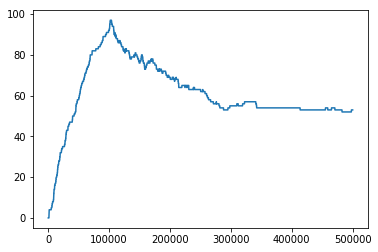

Best number of clicks: 97.0
Best base bid: 101720.344069


In [14]:
#### plot ####
plt.plot(base_bid, clicks)
plt.show()

# best result
print("Best number of clicks:", np.max(clicks))
print("Best base bid:", base_bid[np.argmax(clicks)])

In [10]:
best_base = base_bid[np.argmax(clicks)]
my_bids = best_base*valid_ctr_pred[:,1]

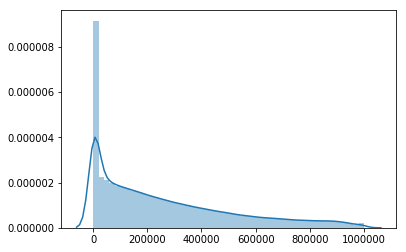

In [11]:
sns.distplot(my_bids)
plt.show()

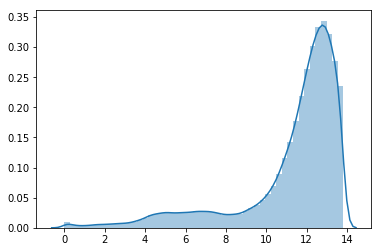

In [12]:
sns.distplot(np.log1p(my_bids))
plt.show()

In [13]:
np.min(my_bids)

2.5259385936216184e-07

In [14]:
np.max(my_bids)

1000999.2315365589

In [15]:
np.median(my_bids)

191549.92757360052

In [16]:
np.mean(my_bids)

264975.17078148108

In [17]:
x = new_performance(best_base*valid_ctr_pred[:,1], valid_y)

               CTR: (0.0640)%
        num_clicks: 49
             spend: 6249802 (100.00)%
              aCPM: 79.3817174937
              aCPC: 127.546979592
num_in_budget_wins: 76503
 ads_within_budget: 78731


# PRINTED "BEST BASE BID" above is wrong

### Run on test set

In [ ]:
submission = pd.read_csv('../Data/Group_01.csv')

In [ ]:
submission.head()

In [ ]:
test_predictions = int(base_bid[np.argmax(clicks)])*CTR_model.predict(test_X)

In [ ]:
submission.bidprice = test_predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv('../Group_01.csv')